In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.0.95:54492' processes=4 cores=16>

In [5]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/AVISO/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

In [28]:
filenames = sorted(glob(LLC_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

Number of files processed: 731


In [29]:
aviso_nc = Dataset(filenames[1],'r')  
aviso_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    cdm_data_type: Grid
    title: DT merged Global Ocean Gridded Absolute Geostrophic Velocities SSALTO/Duacs L4 product
    summary: This dataset contains Delayed Time Level-4 absolute geostrophic velocities products from multi-satellite observations over Global Ocean.
    comment: Surface product; Absolute Geostrophic Velocities
    time_coverage_resolution: P1D
    product_version: 5.0
    institution: CNES, CLS
    project: SSALTO/DUACS
    references: www.aviso.altimetry.fr
    contact: aviso@altimetry.fr
    license: http://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf
    platform: Cryosat-2, Envisat Extension Phase, Jason-1 New Orbit, Jason-2
    date_created: 2014-02-28 17:45:19
    history: 2014-02-28 17:45:19:creation
    Conventions: CF-1.6
    standard_name_vocabulary: http://cf-pcmdi.llnl.gov/documents/cf-standard-names/standard-name-table/12/cf-standard-n

In [125]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):

    #
    file_out = out_dir_nc+'/madt_uv_t%03d.nc'%(i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        aviso_nc = Dataset(filenames[i],'r')         
        lat = aviso_nc.variables['lat'][:]
        lat = np.array(lat)
        lon = aviso_nc.variables['lon'][:]
        lon = np.array(lon)
        time = aviso_nc.variables['time'][:]
        time = np.array(time)
        u = aviso_nc.variables['u'][:]
        u = np.array(u)
        v = aviso_nc.variables['v'][:]
        v = np.array(v)
        #ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time})
        ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time,'lat':lat,'lon':lon})
        
        # ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors
        
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))      

Number of files processed: 731


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [126]:
filenames = sorted(glob(out_dir_nc+'madt_uv_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 731
CPU times: user 4.21 s, sys: 1.45 s, total: 5.66 s
Wall time: 5.71 s
<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
Data variables:
    u        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>


In [130]:
chunks = {'time': 1, 'lat': 720, 'lon': 1440}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
Data variables:
    u        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>


In [131]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_uv_total_rechunk.zarr'
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 4.8 s, sys: 356 ms, total: 5.15 s
Wall time: 6.63 s


# Read rechunked data

In [6]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
Data variables:
    u        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>

 data size: 12.1 GB


In [7]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon       (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time      (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 ...
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ...
Data variables:
    u         (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v         (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>

In [8]:
grid = Grid(ds_full, periodic=['X','Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   lon (1440) --> left
  * left     lon_left (1440) --> center
Y Axis (periodic):
  * center   lat (720) --> left
  * left     lat_left (720) --> center

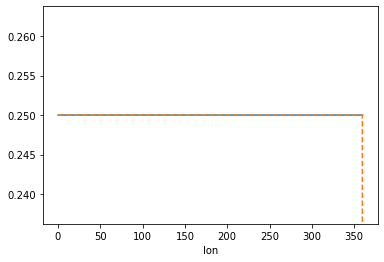

In [9]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

In [10]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc
ds_full

In [30]:
du_dx = grid.diff(ds_full.u.where(ds.u>-20), 'X') / ds_full.dxg
du_dx_ij = grid.interp(du_dx, 'X')
du_dx_ij

<xarray.DataArray 'mul-5723fe936abe4f6d6b6710047202f304' (time: 731, lat: 720, lon: 1440)>
dask.array<shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1)>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

In [31]:
du_dy = grid.diff(ds_full.u.where(ds.u>-20), 'Y') / ds_full.dyg
du_dy_ij = grid.interp(du_dy, 'Y')
du_dy_ij

<xarray.DataArray 'mul-06d94d5238bc42d9c191e19dba214246' (time: 731, lat: 720, lon: 1440)>
dask.array<shape=(731, 720, 1440), dtype=float64, chunksize=(1, 1, 1440)>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

In [32]:
dv_dx = grid.diff(ds_full.v.where(ds.u>-20), 'X') / ds_full.dxg
dv_dx_ij = grid.interp(dv_dx, 'X')
dv_dx_ij

<xarray.DataArray 'mul-709bff31b56cd0302f24d27e0d3a13fa' (time: 731, lat: 720, lon: 1440)>
dask.array<shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1)>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

In [33]:
dv_dy = grid.diff(ds_full.v.where(ds.u>-20), 'Y') / ds_full.dyg
dv_dy_ij = grid.interp(dv_dy, 'Y')
dv_dy_ij

<xarray.DataArray 'mul-a9ba05a759ccc39943ce9aed4789cef7' (time: 731, lat: 720, lon: 1440)>
dask.array<shape=(731, 720, 1440), dtype=float64, chunksize=(1, 1, 1440)>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

## Figures

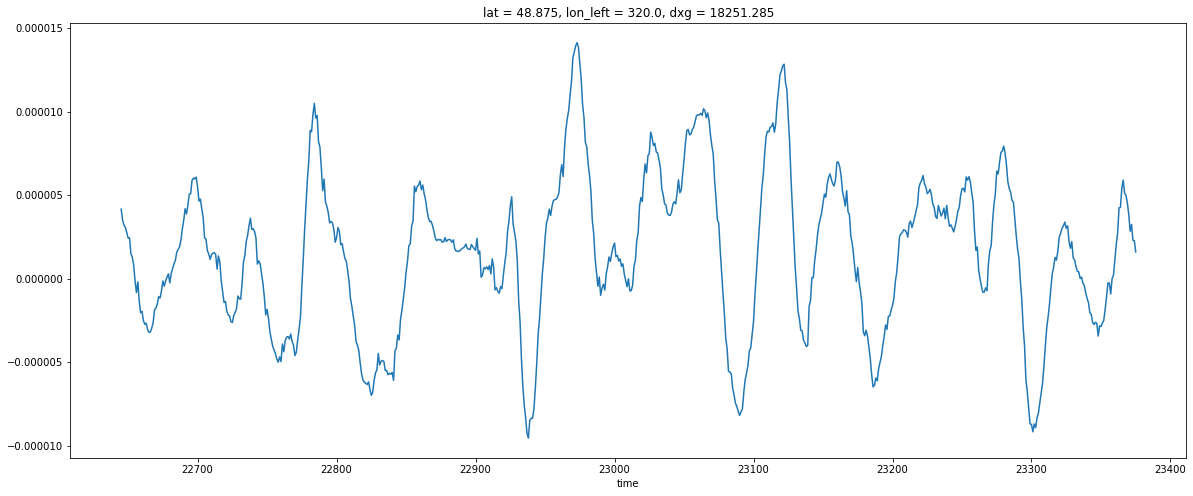

In [25]:
fig = plt.figure(figsize=(20,8))
du_dx.sel(lat=48.75,lon_left=320,method='nearest').plot()

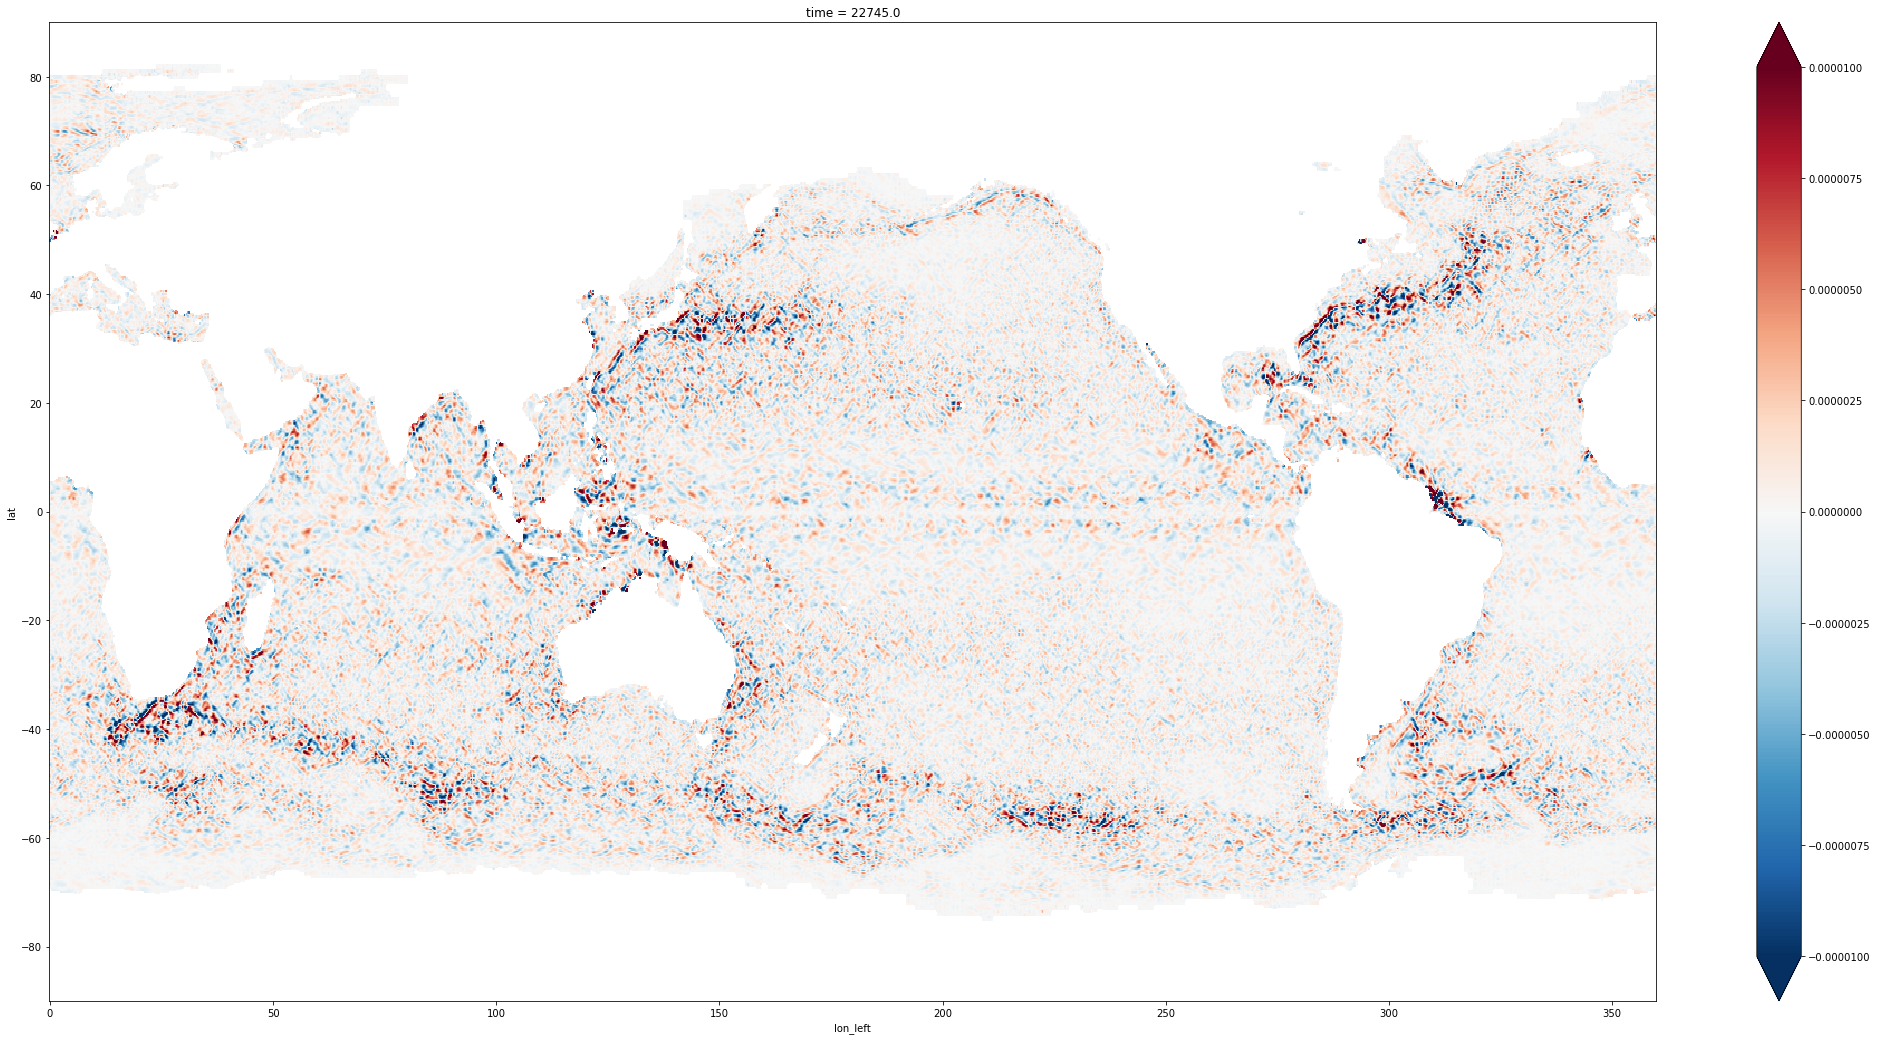

In [27]:
fig = plt.figure(figsize=(36,18))
du_dx.isel(time=100).plot(x='lon_left',y='lat',vmin=-0.00001,vmax=0.00001,cmap='RdBu_r')

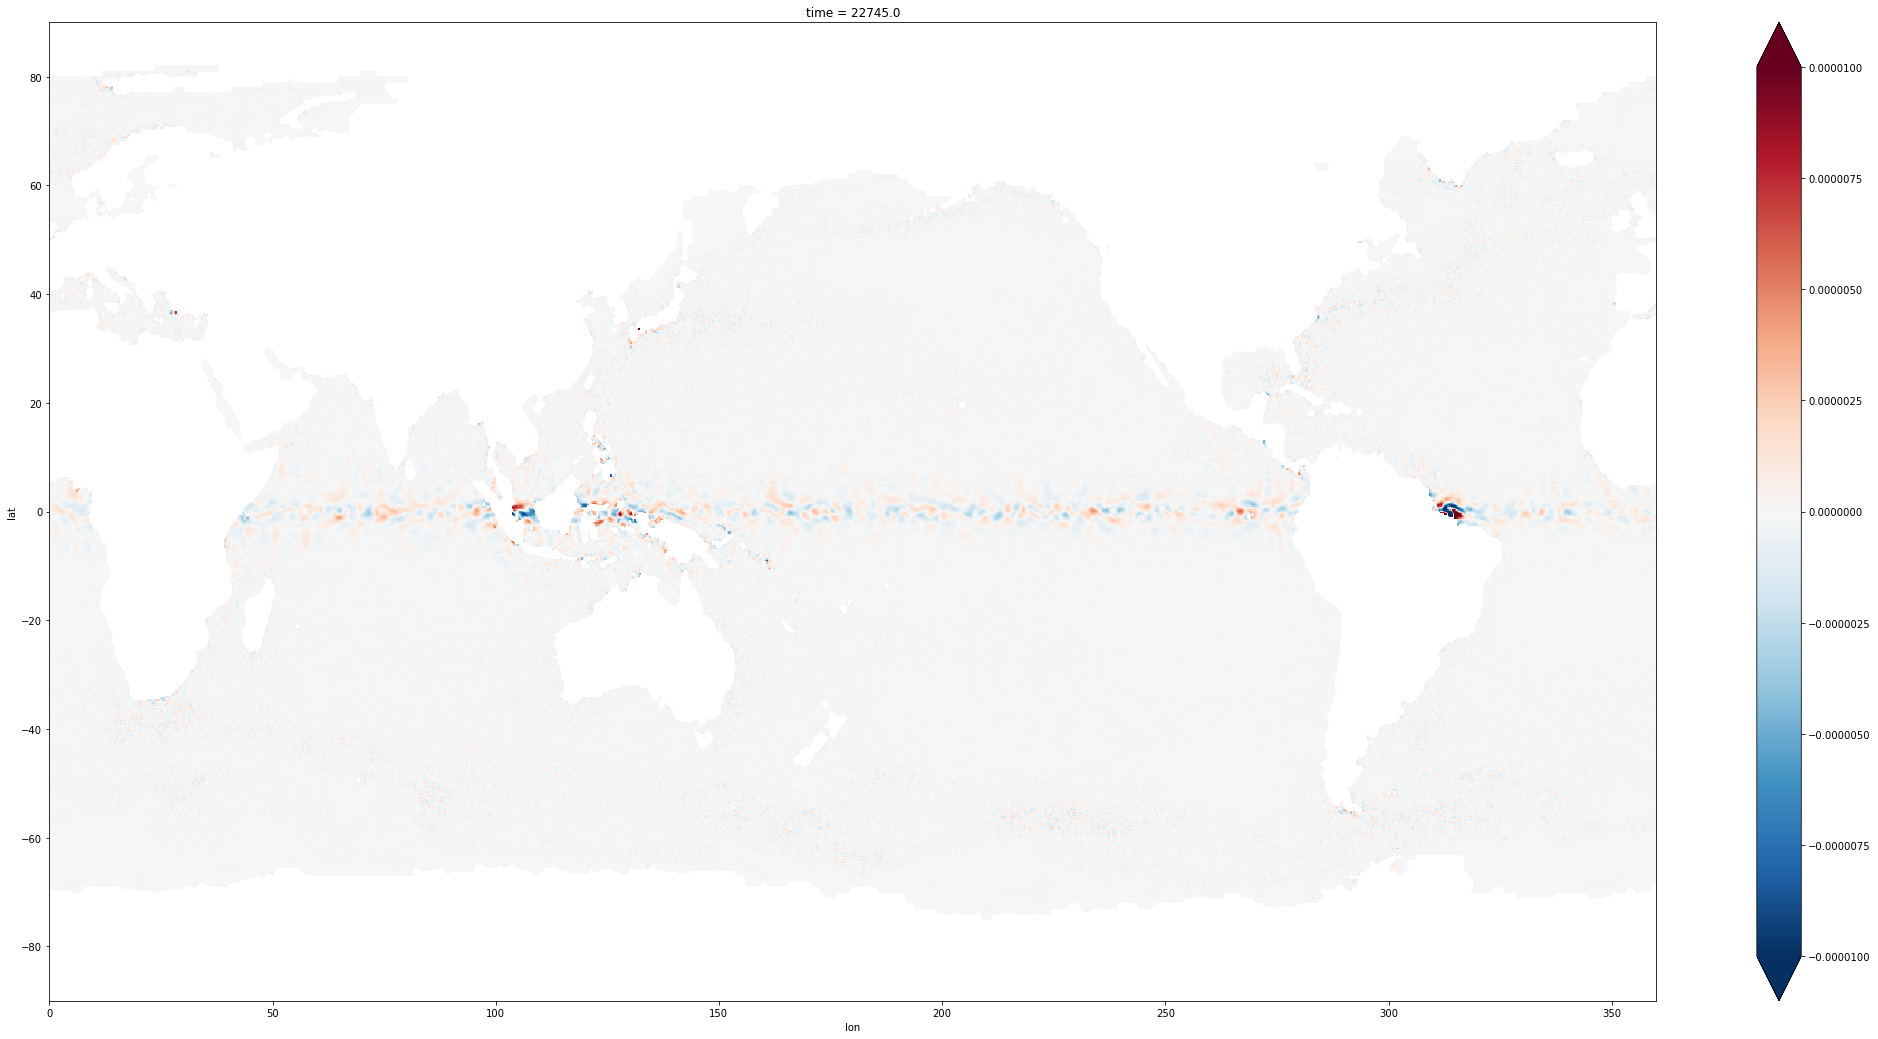

In [36]:
# divergence
fig = plt.figure(figsize=(36,18))
(du_dx_ij+dv_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.00001,vmax=0.00001,cmap='RdBu_r')

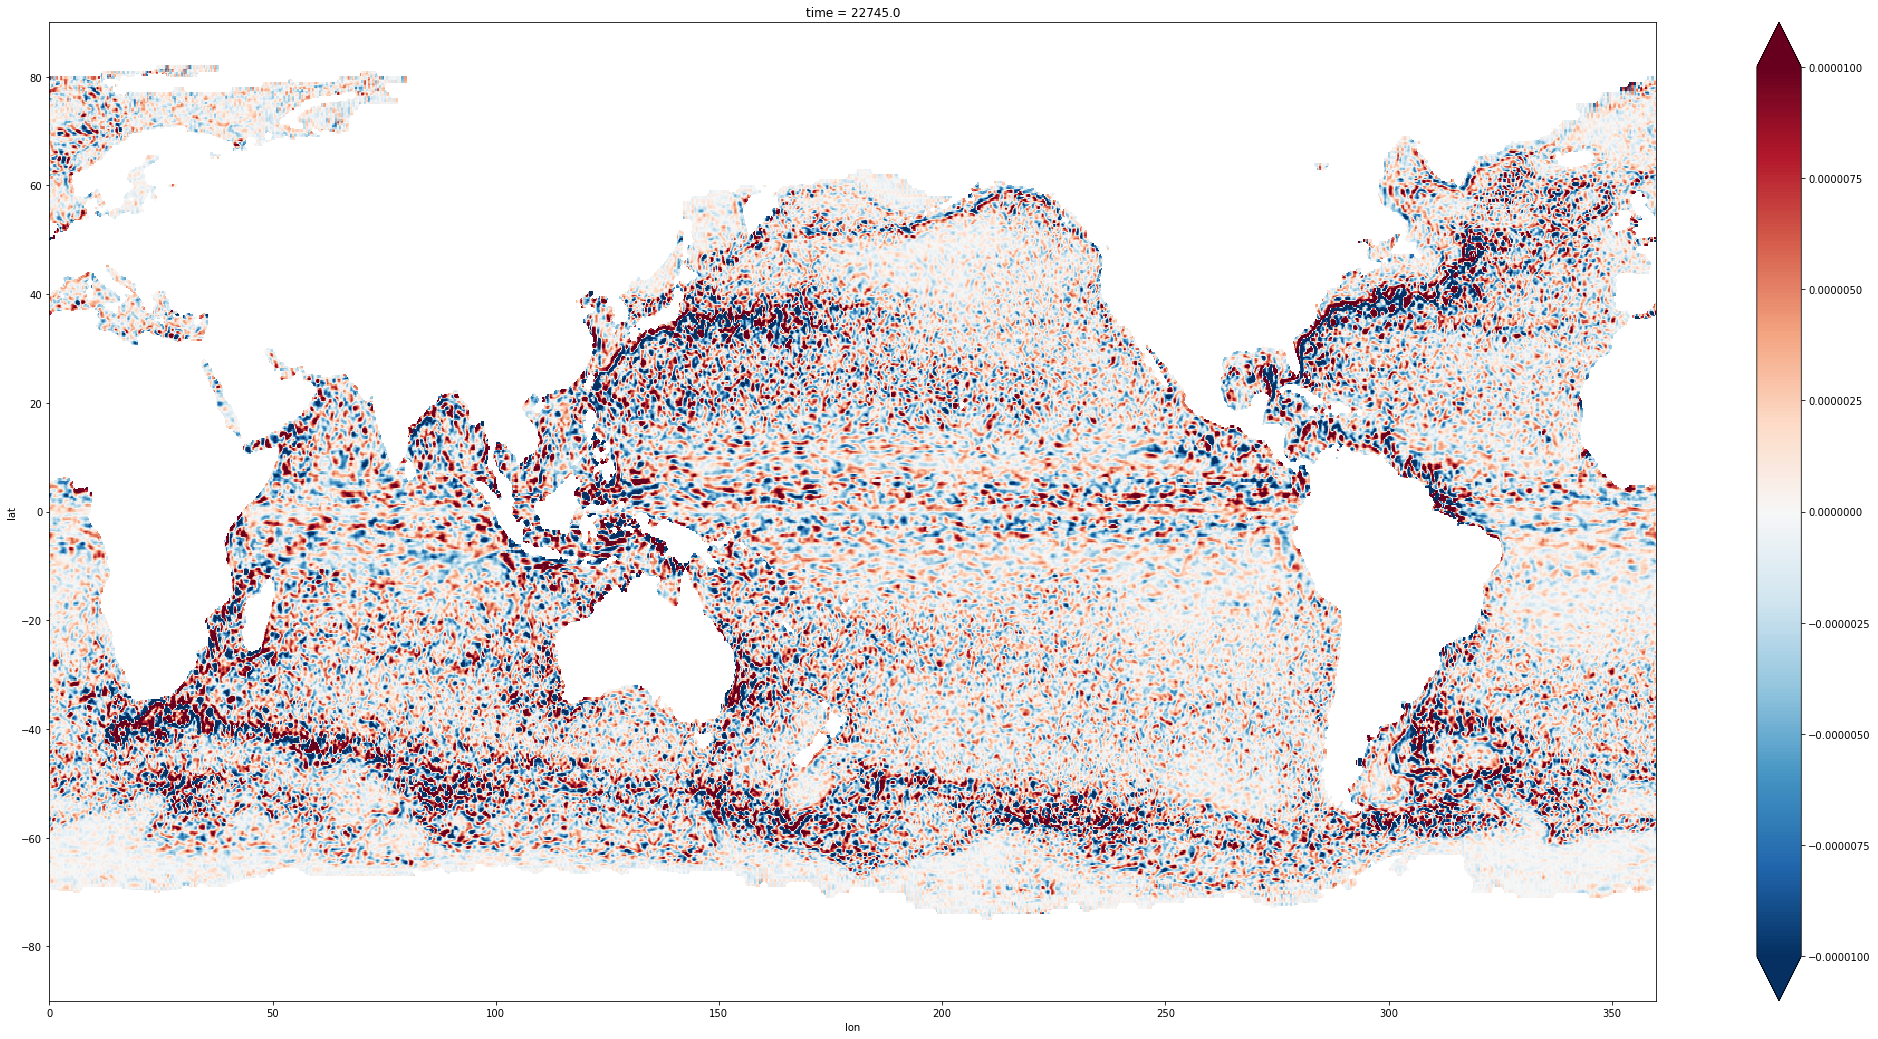

In [37]:
# relative vorticity
fig = plt.figure(figsize=(36,18))
(dv_dx_ij-du_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.00001,vmax=0.00001,cmap='RdBu_r')

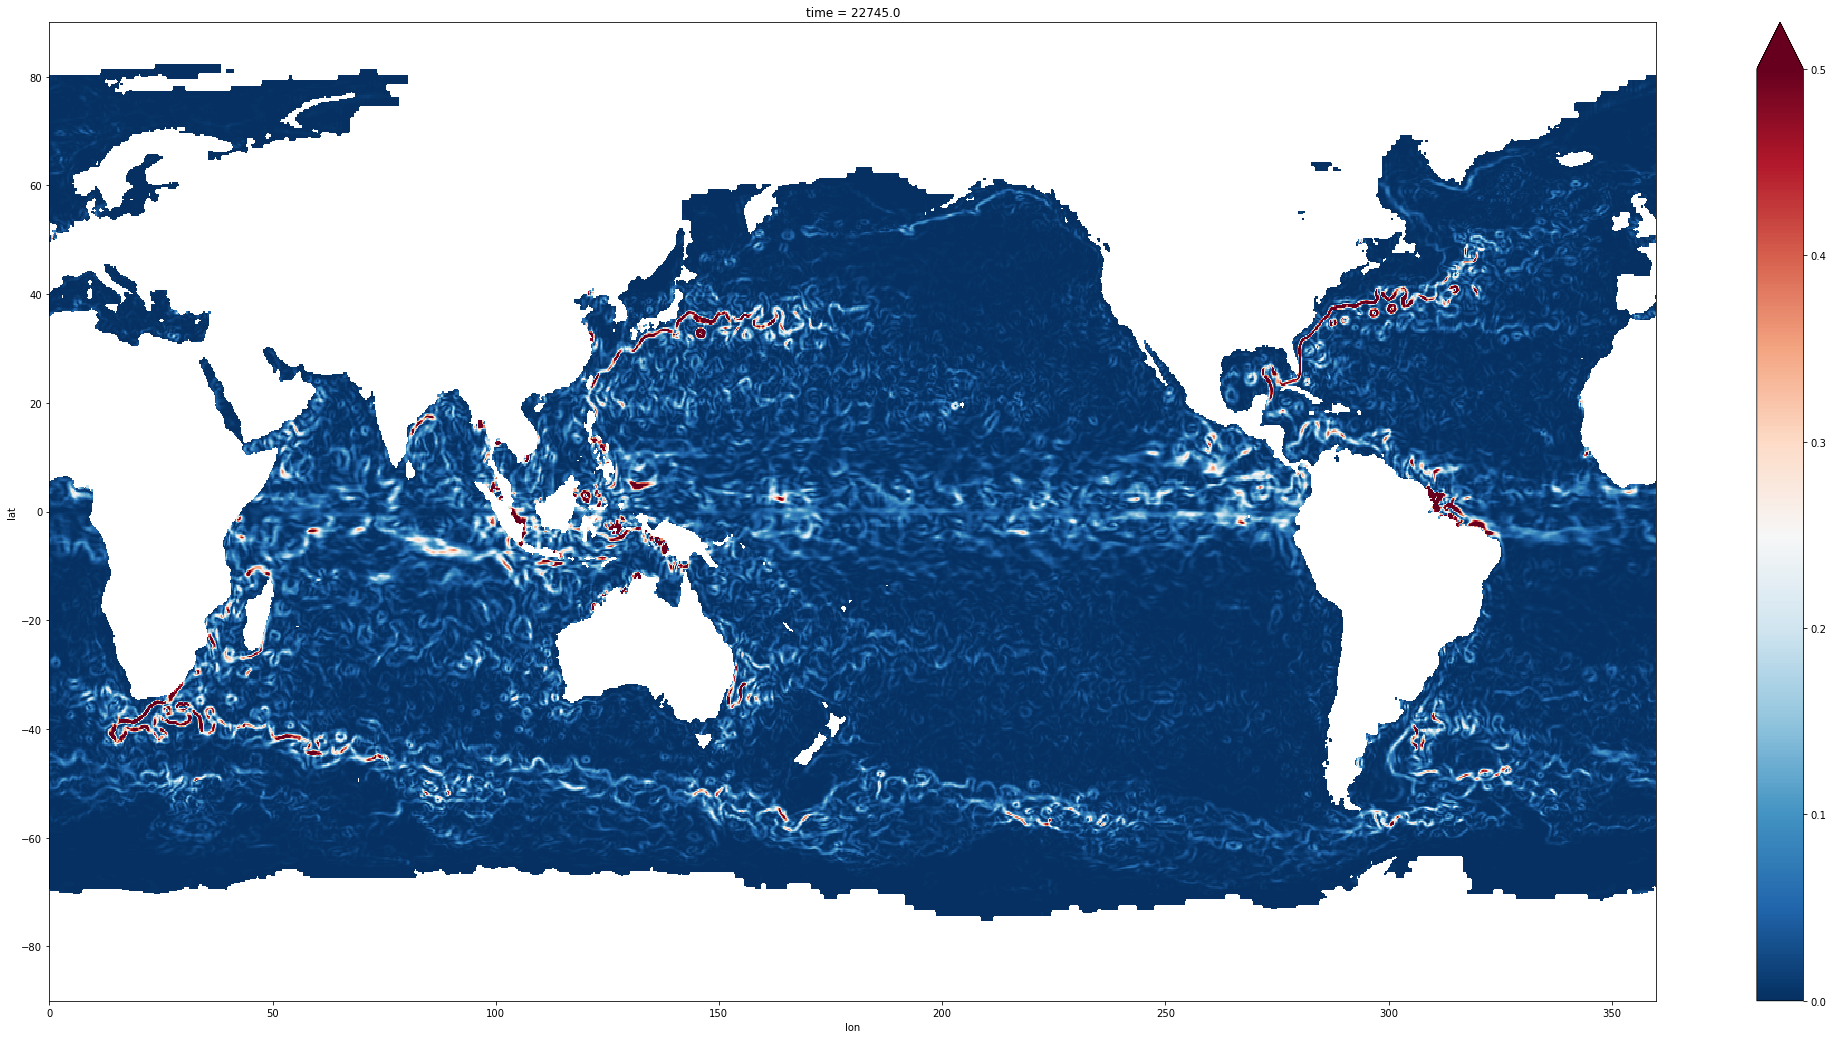

In [40]:
# KE
fig = plt.figure(figsize=(36,18))
(0.5*(ds.v.where(ds.v>-20)**2 + ds.u.where(ds.u>-20)**2)).isel(time=100).plot(x='lon',y='lat',vmin=0,vmax=0.5,cmap='RdBu_r')

In [42]:
cluster.scheduler.close()

<Future finished result=None>